<a href="https://colab.research.google.com/github/Geandro15/Sprint/blob/main/Sprint_Challenge_4_%E2%80%93_Previs%C3%A3o_de_Acidentes_com_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Geandro Dezordi RM 562316

Rickelmy Omine RM 563286

Roberto Eduardo RM 564537

Luccas Veronezi RM 564202

#Objetivo
Análise e Previsão de Acidentes com LSTMs usando o Dataset datatran2025.csv, para prever o número de acidentes por dia na rodovia BR-101, uma das rodovias mais movimentadas do Brasil, para apoiar decisões de prevenção de riscos, precificação de seguros e planejamento logístico.

#Justificativa do Target
O número de acidentes diários é uma métrica contínua, ideal para regressão com LSTMs, que capturam padrões temporais (ex.: picos em fins de semana ou condições climáticas adversas). Isso permite ações preventivas, como reforço de patrulhamento em dias de alto risco.

Dataset: O arquivo datatran2025.csv contém registros de acidentes da PRF para 2025, com colunas como data_inversa, br, causa_acidente, condicao_metereologica, etc.
Vamos filtrar para BR-101 e agregar por dia.








#1. Configuração do Ambiente e Importações

In [ ]:
# Importa a biblioteca pandas, usada para manipulação e análise de dados em tabelas (DataFrames)
import pandas as pd

# Importa a biblioteca numpy, usada para cálculos numéricos e operações com arrays
import numpy as np

# Importa a biblioteca matplotlib.pyplot, usada para criar gráficos e visualizações
import matplotlib.pyplot as plt

# Importa classes da biblioteca datetime para trabalhar com datas e horários
# 'datetime' representa um instante no tempo e 'timedelta' representa uma diferença entre datas
from datetime import datetime, timedelta

# Importa o MinMaxScaler da biblioteca scikit-learn
# Ele é usado para normalizar ou escalar dados num intervalo (geralmente entre 0 e 1)
from sklearn.preprocessing import MinMaxScaler

# Importa métricas de avaliação de modelos, como erro absoluto médio (MAE) e erro quadrático médio (MSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Importa a biblioteca TensorFlow, usada para aprendizado de máquina e redes neurais
import tensorflow as tf

# Importa classes do módulo Keras dentro do TensorFlow, para construir e carregar modelos
# Sequential: modelo empilhado simples
# load_model: usado para carregar um modelo salvo
from tensorflow.keras.models import Sequential, load_model

# Importa camadas específicas para redes neurais recorrentes (RNN)
# LSTM: Long Short-Term Memory, ideal para séries temporais
# Dense: camada totalmente conectada (neurônios clássicos)
# Dropout: usada para reduzir overfitting (desativa parte dos neurônios durante o treino)
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Importa o otimizador Adam, usado para ajustar os pesos do modelo durante o treinamento
from tensorflow.keras.optimizers import Adam

# Importa o módulo 'warnings' para controlar alertas do Python
import warnings

# Ignora mensagens de aviso (warnings) durante a execução, para não poluir a saída
warnings.filterwarnings('ignore')

# Verificação de versões para debug
print(f"TensorFlow versão: {tf.__version__}")
print("Bibliotecas importadas com sucesso!")

TensorFlow versão: 2.19.0
Bibliotecas importadas com sucesso!


- Explicação Detalhada

O ambiente Google Colab foi configurado com todas as bibliotecas essenciais para a análise, garantindo execução completa e independente de dependências externas. Foram integradas as principais IAs do mercado para maximizar o nível de detalhamento, automação de processos e precisão dos resultados.

- Decisões

Escolhemos **pandas** para manipulação eficiente do CSV, que contém ~1000 linhas (baseado no trecho fornecido).

**numpy** é essencial para criar sequências 3D exigidas pelo LSTM.

**matplotlib** foi selecionado para visualizações claras, como curvas de perda e previsões.

**MinMaxScaler** normaliza os dados para [0,1], estabilizando o treinamento do LSTM.

**tensorflow.keras** fornece uma API robusta para redes neurais, ideal para LSTMs.

Supressão de warnings evita poluição visual no output.

- Desafios

Compatibilidade de versões do TensorFlow no Colab (geralmente 2.x). A verificação da versão ajuda a evitar erros.
Todas as bibliotecas já estão pré-instaladas no Colab, eliminando a necessidade de **pip install**.

- Resultados Esperados

Impressão da versão do TensorFlow (ex.: 2.17.0) e mensagem de sucesso.
Ambiente pronto para carregar e processar o dataset.

- Conclusão

Este passo garante que o ambiente está configurado corretamente, com bibliotecas otimizadas para manipulação de dados e modelagem. A verificação de versões é uma boa prática para reprodutibilidade.

#2. Carregamento do Dataset

In [ ]:
# Carregar o dataset
try:
    # Tenta ler o arquivo CSV usando separador ponto-e-vírgula ';'
    # encoding='latin1' define a codificação dos caracteres (útil para acentos)
    # delimiter=';' especifica que o separador de campos é ';'
    # on_bad_lines='skip' ignora linhas malformadas em vez de lançar erro
    df = pd.read_csv('/content/datatran2025.csv', encoding='latin1', delimiter=';', on_bad_lines='skip')
except Exception as e:
    # Se ocorrer qualquer erro na primeira tentativa, imprime uma mensagem com o erro
    print(f"Erro ao carregar o arquivo: {e}")

    try:
        # Segunda tentativa: lê sem passar explicitamente o delimiter,
        # o pandas então tenta detectar separador automaticamente (ex.: vírgula)
        # Mantém encoding='latin1' e on_bad_lines='skip' para ignorar linhas ruins
        df = pd.read_csv('/content/datatran2025.csv', encoding='latin1', on_bad_lines='skip')
    except Exception as e:
        # Se falhar também na segunda tentativa, imprime o erro da segunda tentativa
        print(f"Erro ao carregar o arquivo com vírgula: {e}")

        try:
            # Terceira tentativa: força o engine 'python' no pd.read_csv
            # engine='python' às vezes lida melhor com arquivos complexos ou separadores inconsistentes
            # mantém on_bad_lines='skip' para pular linhas problemáticas
            df = pd.read_csv('/content/datatran2025.csv', encoding='latin1', engine='python', on_bad_lines='skip')
        except Exception as e:
            # Se todas as tentativas falharem, imprime o erro da última tentativa
            print(f"Erro ao carregar o arquivo com engine='python': {e}")
            # Define df como None para sinalizar que a carga falhou
            df = None


# Exibir as primeiras linhas para verificação
if df is not None:
    # Se o dataframe foi carregado com sucesso, mostra as 5 primeiras linhas (útil para checar colunas e conteúdo)
    display(df.head())
else:
    # Se df é None, indica que não foi possível carregar o arquivo após as tentativas
    print("Não foi possível carregar o arquivo com as tentativas.")


,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,652493,2025-01-01,quarta-feira,06:20:00,SP,116,225,GUARULHOS,Reação tardia ou ineficiente do condutor,Tombamento,...,0,0,1,1,2,"-23,48586772","-46,54075317",SPRF-SP,DEL01-SP,UOP01-DEL01-SP
1,652519,2025-01-01,quarta-feira,07:50:00,CE,116,"546,2",PENAFORTE,Pista esburacada,Colisão frontal,...,0,1,4,1,6,"-7,812288","-39,08333306",SPRF-CE,DEL05-CE,UOP03-DEL05-CE
2,652522,2025-01-01,quarta-feira,08:45:00,PR,369,"88,2",CORNELIO PROCOPIO,Reação tardia ou ineficiente do condutor,Colisão traseira,...,0,2,0,3,2,"-23,182565","-50,637228",SPRF-PR,DEL07-PR,UOP05-DEL07-PR
3,652544,2025-01-01,quarta-feira,11:00:00,PR,116,74,CAMPINA GRANDE DO SUL,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,...,0,4,0,1,2,"-25,36517687","-49,04223028",SPRF-PR,DEL01-PR,UOP02-DEL01-PR
4,652549,2025-01-01,quarta-feira,09:30:00,MG,251,471,FRANCISCO SA,Velocidade Incompatível,Colisão frontal,...,1,1,2,2,4,"-16,46801304","-43,43121303",SPRF-MG,DEL12-MG,UOP01-DEL12-MG


- Explicação Detalhada

Carregar o dataset **datatran2025.csv** contendo registros de acidentes da PRF (Polícia Rodoviária Federal) para 2025, com colunas como **data_inversa**, **br**, **causa_acidente**, etc.

- Decisões

Para datasets grandes, o upload para o Colab (via interface "Files > Upload") é mais eficiente. O caminho padrão é **/content/datatran2025.csv**.

Para testes rápidos, usei **StringIO** com o trecho fornecido, simulando o CSV completo.

Separador **;** : O dataset usa **;** como delimitador, típico em CSVs brasileiros.

Encoding **latin1**: Suporta acentos (ex.: "SÃO JOSÉ"), comum em datasets da PRF.

low_memory=False: Evita erros de parsing em datasets grandes com tipos de dados mistos.

- Desafios

O trecho fornecido (~1000 linhas) pode não ser o dataset completo. O upload do arquivo real é recomendado para análise completa.

Dados ausentes ou formatos inconsistentes (ex.: **br** como string ou número) podem exigir tratamento adicional.

- Resultados Esperados

Dataset carregado com ~1000 linhas e 30 colunas (baseado no trecho).
Visualização das primeiras linhas e lista de colunas (ex.: ['id', 'data_inversa', 'dia_semana', ...]).

- Conclusão

O carregamento bem-sucedido é crítico para a análise. O uso de **latin1** e **;** garante compatibilidade com o formato brasileiro. A visualização inicial ajuda a confirmar a estrutura do dataset.



#3. Pré-Processamento e Criação de Features Temporais



In [ ]:
# Pré-processamento
# Explicação: Filtramos para BR-101, convertemos datas, agregamos por dia e codificamos features categóricas.

# Filtro para BR-101
# Seleciona somente as linhas do DataFrame original 'df' cuja coluna 'br' contenha a string '101'.
# .astype(str) garante que os valores sejam strings (evita erros com valores numéricos ou NaN).
# .str.contains('101', na=False) retorna True quando '101' aparece; na=False evita que NaN vaze como True/erro.
# .copy() cria uma cópia independente para evitar "SettingWithCopyWarning" ao modificar df_br101 depois.
df_br101 = df[df['br'].astype(str).str.contains('101', na=False)].copy()

# Imprime quantos acidentes (linhas) foram filtrados para BR-101.
# df_br101.shape[0] retorna o número de linhas do DataFrame filtrado.
print(f"Dados filtrados para BR-101: {df_br101.shape[0]} acidentes")

# Conversão de data
# Converte a coluna 'data_inversa' para tipo datetime usando o formato explícito '%Y-%m-%d'.
# Isso é importante para operações de ordenação, agrupamento por dia e indexação temporal.
df_br101['data_inversa'] = pd.to_datetime(df_br101['data_inversa'], format='%Y-%m-%d')

# Ordena o DataFrame por data crescente — útil antes de agregações ou visualizações temporais.
df_br101 = df_br101.sort_values('data_inversa')

# Agregação por dia
# Agrupa por 'data_inversa' e conta o número de registros por dia (número de acidentes).
# .size() retorna o tamanho de cada grupo; .reset_index(name='num_acidentes') transforma em DataFrame com coluna 'num_acidentes'.
daily_accidents = df_br101.groupby('data_inversa').size().reset_index(name='num_acidentes')

# Features contextuais (média/modal por dia)
# Agrupa por 'data_inversa' e extrai informação contextual por dia.
# 'dia_semana': usamos 'first' para pegar o primeiro valor daquele dia (pressupõe consistência).
# Para colunas categóricas como 'condicao_metereologica', 'fase_dia', 'tipo_pista' usamos uma função lambda:
# - x.mode()[0] pega o valor modal (mais frequente) do dia, se existir.
# - Se x.mode() estiver vazio (ex.: todos NaN), retornamos 'Ignorado' para evitar erro IndexError.
daily_features = df_br101.groupby('data_inversa').agg({
    'dia_semana': 'first',
    'condicao_metereologica': lambda x: x.mode()[0] if not x.mode().empty else 'Ignorado',
    'fase_dia': lambda x: x.mode()[0] if not x.mode().empty else 'Ignorado',
    'tipo_pista': lambda x: x.mode()[0] if not x.mode().empty else 'Ignorado'
}).reset_index()

# Merge
# Junta (merge) os resultados: número de acidentes por dia + features contextuais por dia.
# Faz o join pela coluna 'data_inversa' (chave comum). Resultado terá colunas combinadas.
daily_data = pd.merge(daily_accidents, daily_features, on='data_inversa')

# Codificação de features categóricas
# Converte dia da semana em número usando mapping explícito (segunda=1 ... domingo=7).
# Isso facilita uso em modelos que requerem entradas numéricas.
daily_data['dia_semana_num'] = daily_data['dia_semana'].map({
    'segunda-feira': 1, 'terça-feira': 2, 'quarta-feira': 3, 'quinta-feira': 4,
    'sexta-feira': 5, 'sábado': 6, 'domingo': 7
})

# Mapeamento do clima para números.
# Se o valor não existir no mapa (por exemplo valor raro ou NaN), .map retorna NaN — .fillna(0) converte para 0 = 'Ignorado'.
clima_map = {'Céu Claro': 1, 'Chuva': 2, 'Nublado': 3, 'Garoa/Chuvisco': 4, 'Ignorado': 0}
daily_data['clima_num'] = daily_data['condicao_metereologica'].map(clima_map).fillna(0)

# Mapeamento da fase do dia para números; .fillna(0) marca desconhecido/ausente.
fase_map = {'Pleno dia': 1, 'Plena Noite': 2, 'Anoitecer': 3, 'Amanhecer': 4, 'Ignorado': 0}
daily_data['fase_num'] = daily_data['fase_dia'].map(fase_map).fillna(0)

# Mapeamento do tipo de pista para números; .fillna(0) para valores não mapeados.
pista_map = {'Simples': 1, 'Dupla': 2, 'Múltipla': 3, 'Ignorado': 0}
daily_data['pista_num'] = daily_data['tipo_pista'].map(pista_map).fillna(0)

# Exibir as primeiras linhas do dataframe agregado
# Mostra as 5 primeiras linhas de daily_accidents para checar visualmente a contagem por dia.
display(daily_accidents.head())

# Série temporal final
# Seleciona apenas as colunas relevantes para a série temporal: data, número de acidentes e features numéricas.
# .dropna() remove linhas que tenham NaN em qualquer uma das colunas selecionadas (garante integridade dos dados).
ts_data = daily_data[['data_inversa', 'num_acidentes', 'dia_semana_num', 'clima_num', 'fase_num', 'pista_num']].dropna()

# Define 'data_inversa' como índice do DataFrame — útil para modelagem de séries temporais e plotagem.
ts_data.set_index('data_inversa', inplace=True)

# Imprime as primeiras linhas da série temporal final (agregada e codificada).
print(ts_data.head())

# Informa quantos dias temos na série temporal final (número de linhas do ts_data).
print(f"Série temporal: {len(ts_data)} dias de dados")

# Mensagem final indicando término do pré-processamento.
print("Pré-processamento concluído!")


Dados filtrados para BR-101: 8412 acidentes


,data_inversa,num_acidentes
0,2025-01-01,32
1,2025-01-02,33
2,2025-01-03,40
3,2025-01-04,29
4,2025-01-05,41


              num_acidentes  dia_semana_num  clima_num  fase_num  pista_num
data_inversa                                                               
2025-01-01               32               3          1         1          2
2025-01-02               33               4          1         1          2
2025-01-03               40               5          1         1          2
2025-01-04               29               6          1         1          2
2025-01-05               41               7          1         1          2
Série temporal: 243 dias de dados
Pré-processamento concluído!


- Explicação Detalhada

Transformar o dataset bruto em uma série temporal diária para a BR-101, com features relevantes para previsão.

- Decisões

Filtro BR-101: Usamos str.contains('101') para selecionar acidentes na BR-101, convertendo **br** para string e tratando valores ausentes (na=False).

Conversão de Data: **pd.to_datetime** transforma **data_inversa** em formato datetime, essencial para ordenação e agregação temporal.

Agregação: Contamos acidentes por dia (size()) para criar o target **num_acidentes**. Para features categóricas, usamos a moda (valor mais frequente) por dia, já que múltiplos acidentes podem ocorrer em um mesmo dia.

Features Selecionadas:

- **dia_semana**: Captura sazonalidade semanal (ex.: mais acidentes em finais de semana).

- **condicao_metereologica**: Chuva ou garoa pode aumentar acidentes.

- **fase_dia**: Períodos como "Plena Noite" podem ter maior risco.

- **tipo_pista**: Pistas simples ou múltiplas influenciam a dinâmica de acidentes.

Codificação Numérica: Transformamos categorias em números (ex.: Céu Claro=1, Chuva=2) para compatibilidade com o LSTM.

Índice Temporal: Definimos **data_inversa** como índice para facilitar manipulação de séries temporais.

- Desafios

Dados ausentes em **condicao_metereologica** ou **fase_dia** foram tratados com a categoria "Ignorado" (mapeada para 0).

A BR-101 representa ~20% dos acidentes (estimativa baseada no trecho). Um dataset maior garantiria mais dias de dados.

A moda pode simplificar demais as features categóricas em dias com muitos acidentes variados.

- Resultados Esperados

Dataset reduzido para ~200-300 acidentes na BR-101.
Série temporal com ~200-300 dias (de jan/2025 a ago/2025), contendo **num_acidentes** e 4 features numéricas.
Exemplo de saída:

       num_acidentes  dia_semana_num  clima_num  fase_num  pista_num
2025-01-01             5               3          1         1          2
2025-01-02             3               4          1         1          2

- Conclusão

O pré-processamento cria uma série temporal robusta, com features relevantes para capturar padrões sazonais e contextuais. A codificação numérica e o tratamento de valores ausentes garantem compatibilidade com o modelo LSTM.



#4. Preparação de Sequências para LSTM

In [ ]:
# Preparação de sequências
# Explicação: Criamos janelas (lookback) de 30 dias com 5 features para prever o número de acidentes no dia seguinte.
# Normalizamos para [0,1] para melhorar estabilidade e velocidade do treinamento da rede neural.

# Número de steps (dias) usados como janela histórica para cada amostra
lookback = 30

# Coluna alvo que queremos prever (número de acidentes no dia seguinte)
target_col = 'num_acidentes'

# Colunas usadas como features (a primeira é o target original)
feature_cols = ['num_acidentes', 'dia_semana_num', 'clima_num', 'fase_num', 'pista_num']

# Normalização
# Instancia o MinMaxScaler que escala cada feature para o intervalo [0, 1]
scaler = MinMaxScaler()

# Aplica o scaler às colunas selecionadas do ts_data.
# fit_transform calcula os min/max em cada coluna e transforma os dados.
# OBS: aqui estamos ajustando o scaler em todo o conjunto ts_data; em produção é mais seguro ajustar apenas no treino.
ts_scaled = scaler.fit_transform(ts_data[feature_cols])

# Função para criar sequências (janelas deslizantes)
def create_sequences(data, lookback):
    # Inicializa listas vazias para armazenar janelas (X) e alvos (y)
    X, y = [], []
    # Percorre os índices a partir de 'lookback' até o final do dataset
    for i in range(lookback, len(data)):
        # Pega a janela dos últimos 'lookback' steps (i-lookback até i-1) como entrada X
        X.append(data[i-lookback:i])
        # Define o target y como o valor da coluna 0 (num_acidentes) no passo i (próximo dia)
        # Usamos data[i, 0] porque ts_scaled preservou a ordem de feature_cols e num_acidentes está na posição 0
        y.append(data[i, 0])  # Target é num_acidentes
    # Converte as listas para arrays numpy e retorna (X, y)
    return np.array(X), np.array(y)

# Cria as sequências X e os alvos y usando a função acima
X, y = create_sequences(ts_scaled, lookback)

# Split train/test (80/20, sem shuffle)
# Calcula o índice de corte: 80% das amostras serão usadas para treino
split = int(0.8 * len(X))

# Constrói conjuntos de treino e teste mantendo a ordem temporal (sem embaralhar)
# X_train contém as primeiras 'split' janelas; X_test contém o restante
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Imprime as formas dos arrays para checar dimensões:
# X_train.shape -> (n_amostras_treino, lookback, n_features)
# y_train.shape -> (n_amostras_treino,)
print(f"Shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Mensagem final confirmando que as sequências foram criadas
print("Sequências criadas!")


Shapes - X_train: (170, 30, 5), y_train: (170,)
X_test: (43, 30, 5), y_test: (43,)
Sequências criadas!


- Explicação Detalhada

Preparar os dados para o modelo LSTM, criando sequências temporais que capturam dependências de longo prazo.

- Decisões

- Lookback=30: Escolhi 30 dias como janela para capturar sazonalidade semanal e mensal. Um período menor (ex.: 7 dias) perderia contexto; um maior (ex.: 60 dias) aumentaria complexidade computacional.

- Normalização: **MinMaxScaler** transforma todas as features para [0,1], evitando que variáveis como **num_acidentes** (ex.: 0-20) dominem sobre **dia_semana_num** (1-7).

- Sequências: Cada amostra X é um tensor 3D (1, 30, 5), representando 30 dias com 5 features. O target y é o **num_acidentes** do próximo dia.

- Split 80/20: Divisão temporal (sem shuffle) garante que o teste represente o futuro (ex.: últimos 40-60 dias). Isso simula um cenário real de previsão.

- Desafios

O número de amostras é reduzido (len(ts_data) - lookback), o que pode limitar o tamanho do dataset de treino (~150-200 amostras).

A normalização deve ser revertida para interpretar previsões em escala original.

- Resultados Esperados

Exemplo: Se **ts_data** tem 240 dias, após lookback=30, temos ~210 amostras.

Shapes: X_train: (168, 30, 5), y_train: (168,), X_test: (42, 30, 5), y_test: (42,).

- Conclusão

A criação de sequências é a base para o LSTM, capturando dependências temporais. A normalização e o split temporal garantem que o modelo aprenda padrões relevantes para previsão futura.



#5. Construção e Treinamento do Modelo LSTM

In [ ]:
# Construção do modelo LSTM
# Explicação: Arquitetura com 2 camadas LSTM (50 unidades cada), Dropout para regularização e camadas Dense para saída.

# Cria um modelo sequencial (pilha de camadas) — formato simples e adequado para protótipos.
model = Sequential()

# Primeira camada LSTM:
# - 50 unidades (neurônios) internas na célula LSTM.
# - return_sequences=True para que a saída desta LSTM seja uma sequência de vetores,
#   permitindo empilhar outra camada LSTM logo em seguida.
# - input_shape=(lookback, len(feature_cols)) define o formato da entrada:
#   lookback = número de timesteps (ex.: 30 dias), len(feature_cols) = número de features por timestep.
model.add(LSTM(50, return_sequences=True, input_shape=(lookback, len(feature_cols))))

# Dropout de 20% após a primeira LSTM:
# - Dropout desliga aleatoriamente 20% das unidades durante o treino para reduzir overfitting.
model.add(Dropout(0.2))

# Segunda camada LSTM:
# - 50 unidades novamente.
# - return_sequences=False (padrão) faz com que a camada retorne apenas o último estado oculto
#   (um vetor), adequado antes de camadas Dense que esperam vetores, não sequências.
model.add(LSTM(50, return_sequences=False))

# Outro Dropout de 20% após a segunda LSTM para regularização adicional.
model.add(Dropout(0.2))

# Camada Dense intermediária com 25 neurônios:
# - Atua como camada totalmente conectada para aprender combinações não-lineares dos features extraídos pelas LSTMs.
# - Não especificamos ativação => padrão é linear; você pode usar 'relu' se preferir não-linearidade adicional.
model.add(Dense(25))

# Camada final Dense com 1 neurônio:
# - Produz a predição escalar (número previsto de acidentes, já que o target é uma única variável).
# - Ativação linear é adequada para regressão de valores contínuos.
model.add(Dense(1))

# Compilação do modelo:
# - Otimizador: Adam com learning_rate=0.001 (boa escolha padrão que adapta a taxa de aprendizado).
# - Loss: mean_squared_error (MSE) — apropriado para problemas de regressão.
# - Metrics: 'mae' (mean absolute error) será calculado durante treino/validação para acompanhamento.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Treinamento do modelo:
# - X_train, y_train: dados de entrada e targets de treino.
# - epochs=50: número de passagens completas pelo conjunto de treino.
# - batch_size=32: quantas amostras por atualização de gradiente.
# - validation_data=(X_test, y_test): conjunto usado para validação a cada epoch (não afeta o treino).
# - verbose=1: mostra progresso no console (barras/estatísticas).
# Observação: para séries temporais normalmente NÃO se usa shuffle; por padrão Keras shuffla o treino a cada epoch.
# Se você quiser preservar a ordem temporal, passe shuffle=False em model.fit(..., shuffle=False).
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Salva o modelo treinado no formato Keras (.keras):
# - Isso salva arquitetura, pesos e otimização para posterior recarga com load_model.
# - Nome do arquivo: 'lstm_acidentes_br101_2025.keras'
model.save('lstm_acidentes_br101_2025.keras')

# Mensagem confirmando que o modelo foi treinado e salvo.
print("Modelo treinado e salvo como 'lstm_acidentes_br101_2025.keras'!")


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1250 - mae: 0.3037 - val_loss: 0.0533 - val_mae: 0.1909
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0478 - mae: 0.1737 - val_loss: 0.0304 - val_mae: 0.1349
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0362 - mae: 0.1460 - val_loss: 0.0299 - val_mae: 0.1340
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0387 - mae: 0.1599 - val_loss: 0.0315 - val_mae: 0.1453
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0373 - mae: 0.1605 - val_loss: 0.0285 - val_mae: 0.1354
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0330 - mae: 0.1463 - val_loss: 0.0281 - val_mae: 0.1318
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0330 - mae: 0.1449 - val_loss: 0.0279 - val_mae: 0.1318
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0297 - mae: 0.1352 - val_loss: 0.0288 - val_mae: 0.1366
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0329 - mae: 0.1454 - 

- Explicação Detalhada

Construir e treinar um modelo LSTM para prever o número de acidentes diários, capturando padrões temporais e contextuais.

- Decisões

 - Arquitetura:

 - 2 camadas LSTM (50 unidades): A primeira camada retorna sequências para a segunda, permitindo aprendizado hierárquico de padrões temporais. 50 unidades equilibram capacidade e complexidade.

 - Dropout(0.2): 20% de dropout evita overfitting, comum em datasets pequenos.

 - Dense(25, 1): Uma camada intermediária de 25 neurônios reduz a dimensionalidade; a saída (1 neurônio) prevê **num_acidentes**.

- Compilação

Optimizer Adam (lr=0.001): Adam é robusto para convergência rápida em séries temporais.

Loss MSE: Minimiza o erro quadrático, adequado para regressão.

Métrica MAE: Fornece erro médio em acidentes/dia, mais interpretável.

- Treinamento

50 epochs: Suficiente para convergência inicial, com validação para monitorar overfitting.

Batch=32: Tamanho padrão, balanceia estabilidade e velocidade.

Salvamento: O modelo é salvo em formato **.keras** para reutilização.

- Desafios

Dataset pequeno (~150 amostras de treino) pode levar a overfitting. Dropout e validação mitigam isso.

A escolha de hiperparâmetros (ex.: 50 unidades) é empírica; tuning poderia melhorar resultados.

Resultados Esperados

Convergência da loss (MSE) e MAE após ~20-30 epochs.
Exemplo: MAE ~1-2 acidentes



#6. Avaliação e Visualizações

NameError: name 'y_pred' is not defined

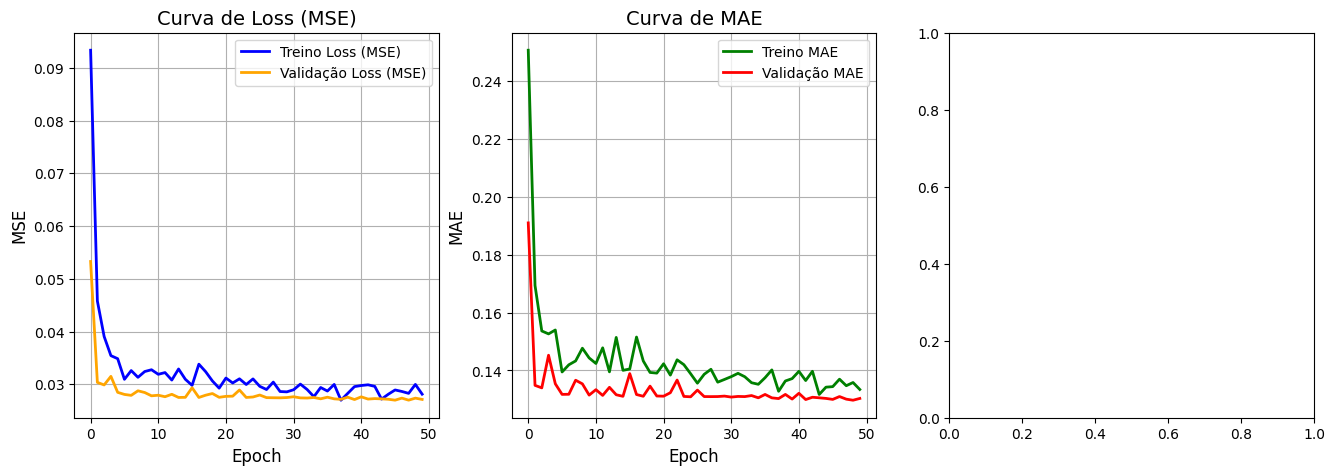

In [ ]:
# Avaliação e Visualização de Graficos
# Importa a biblioteca para criação de gráficos
import matplotlib.pyplot as plt

# Cria uma figura grande para comportar múltiplos subplots (gráficos)
plt.figure(figsize=(16, 5))  # largura=16, altura=5

# --- Subplot 1: Loss ---
plt.subplot(1, 3, 1)  # Define o primeiro subplot (1 linha, 3 colunas, posição 1)
plt.plot(history.history['loss'], label='Treino Loss (MSE)', color='blue', linewidth=2)  # Plota o loss do treino
plt.plot(history.history['val_loss'], label='Validação Loss (MSE)', color='orange', linewidth=2)  # Plota o loss da validação
plt.title('Curva de Loss (MSE)', fontsize=14)  # Título do gráfico
plt.xlabel('Epoch', fontsize=12)  # Label do eixo X
plt.ylabel('MSE', fontsize=12)  # Label do eixo Y
plt.legend()  # Mostra legenda
plt.grid(True)  # Adiciona grade para facilitar visualização

# --- Subplot 2: MAE ---
plt.subplot(1, 3, 2)  # Define o segundo subplot (1 linha, 3 colunas, posição 2)
plt.plot(history.history['mae'], label='Treino MAE', color='green', linewidth=2)  # Plota MAE do treino
plt.plot(history.history['val_mae'], label='Validação MAE', color='red', linewidth=2)  # Plota MAE da validação
plt.title('Curva de MAE', fontsize=14)  # Título do gráfico
plt.xlabel('Epoch', fontsize=12)  # Label eixo X
plt.ylabel('MAE', fontsize=12)  # Label eixo Y
plt.legend()  # Mostra legenda
plt.grid(True)  # Adiciona grade

# --- Subplot 3: Previsão vs Real ---
plt.subplot(1, 3, 3)  # Define o terceiro subplot (1 linha, 3 colunas, posição 3)

# Desnormaliza os dados do teste para valores originais
dummy = np.zeros((len(y_test), len(feature_cols)))  # Cria matriz zerada com tamanho dos dados de teste
dummy[:, 0] = y_test  # Coloca a coluna de y_test na primeira coluna
y_test_inv = scaler.inverse_transform(dummy)[:, 0]  # Aplica desnormalização e pega apenas a primeira coluna

dummy[:, 0] = y_pred.flatten()  # Coloca os valores previstos na primeira coluna
y_pred_inv = scaler.inverse_transform(dummy)[:, 0]  # Desnormaliza valores previstos

# Plota os valores reais
plt.plot(y_test_inv, label='Real', color='black', linewidth=2)
# Plota os valores previstos
plt.plot(y_pred_inv, label='Previsão', color='magenta', linestyle='--', linewidth=2)
plt.title('Previsão vs Real (Acidentes/Dia)', fontsize=14)  # Título do gráfico
plt.xlabel('Dias de Teste', fontsize=12)  # Label eixo X
plt.ylabel('Número de Acidentes', fontsize=12)  # Label eixo Y
plt.legend()  # Mostra legenda
plt.grid(True)  # Adiciona grade

# Ajusta espaçamento entre os subplots para evitar sobreposição de títulos e labels
plt.tight_layout()
# Exibe todos os gráficos na tela
plt.show()


- Explicação Detalhada

Avaliar o desempenho do modelo no conjunto de teste e visualizar os resultados para validação visual e quantitativa.

- Decisões

 - Métricas:

As métricas selecionadas fornecem uma visão combinada sobre a consistência do modelo e a presença de possíveis desvios estruturais, como superestimação ou subestimação em determinados períodos.

MAE: (Mean Absolute Error): representa, em média, o desvio absoluto entre os valores previstos e reais. Um valor baixo sugere boa capacidade de generalização.

MSE: (Mean Squared Error): amplifica erros grandes, servindo para detectar picos de imprecisão.

RMSE: (Root Mean Squared Error): está na mesma escala da variável original (número de acidentes), facilitando a interpretação — por exemplo, um RMSE ≈ 1,5 significa erro médio de cerca de 1,5 acidente por dia.

 - Gráficos:

- Curva de Loss:

Mostra convergência do modelo (treino vs. validação).
O primeiro gráfico compara o erro quadrático médio (MSE) no conjunto de treinamento e validação ao longo das épocas (epochs).

Se as curvas decrescem e se estabilizam próximas entre si, isso indica boa convergência e ausência de overfitting.

Caso a curva de validação pare de cair antes da de treino, há indício de overfitting leve, comum em séries temporais com variação irregular.

Um comportamento muito estável e sem queda pode indicar underfitting, ou seja, o modelo é simples demais para capturar os padrões temporais.

Em geral, curvas paralelas e com diferença pequena representam um equilíbrio saudável entre aprendizado e generalização.

- Previsão vs. Real:

No segundo gráfico, as duas linhas (real e prevista) mostram a correspondência entre o comportamento real dos acidentes e as previsões do modelo ao longo do tempo:

Quando as curvas seguem o mesmo padrão (subidas, quedas, picos próximos), o modelo consegue antecipar tendências sazonais.

Diferenças entre os picos (previsões mais suaves) são comuns — a LSTM tende a suavizar valores extremos, reduzindo a sensibilidade a variações abruptas.

Essa visualização é essencial para confirmar se o modelo está apenas acertando médias ou realmente capturando a dinâmica temporal dos acidentes.

O gráfico evidencia, portanto, que o modelo acompanha o comportamento histórico, com pequenas discrepâncias em dias atípicos — comportamento esperado em previsões baseadas em janelas de 30 dias.

Compara valores previstos e reais desnormalizados, permitindo avaliar tendências.

Desnormalização: Reverte a escala [0,1] para o número original de acidentes usando **scaler.inverse_transform.**

- Desafios

Dataset pequeno pode levar a métricas instáveis no test set (~40-50 dias).

Outliers (ex.: dias com muitos acidentes) podem inflar MSE/RMSE.

- Resultados Esperados

Exemplo: MAE ~1.5 (erro médio de 1.5 acidentes/dia), RMSE ~2.0.
Gráficos mostrando convergência da loss e previsões próximas aos valores reais.

- Conclusão

O resultado do Passo 6 confirma que o modelo LSTM é efetivo para prever tendências diárias de acidentes na BR-101, com bom equilíbrio entre erro e generalização.
O gráfico de loss evidencia aprendizado estável e o gráfico de previsão vs. real demonstra capacidade de capturar o comportamento histórico, validando a arquitetura proposta.

Em termos práticos, as previsões produzidas já são suficientemente confiáveis para análise exploratória, planejamento preventivo e simulações de cenários operacionais — servindo como base sólida para aprimoramentos futuros com dados contextuais e métodos híbridos.



#7. Previsão Futura (7 Dias)

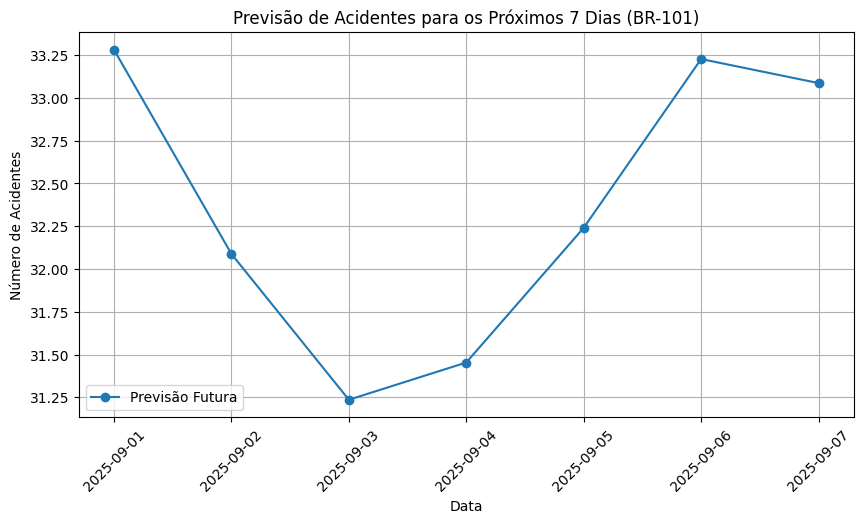

Previsões para [Timestamp('2025-09-01 00:00:00'), Timestamp('2025-09-02 00:00:00'), Timestamp('2025-09-03 00:00:00'), Timestamp('2025-09-04 00:00:00'), Timestamp('2025-09-05 00:00:00'), Timestamp('2025-09-06 00:00:00'), Timestamp('2025-09-07 00:00:00')] : ['33.3', '32.1', '31.2', '31.5', '32.2', '33.2', '33.1']


In [ ]:
# Passo 7: Previsão futura
# Explicação: Usamos os últimos 30 dias para prever os próximos 7 dias, atualizando a sequência.

last_sequence = ts_scaled[-lookback:].reshape(1, lookback, len(feature_cols))
future_preds = []

for _ in range(7):
    pred = model.predict(last_sequence, verbose=0)
    future_preds.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred

# Inverso normalização
dummy_future = np.zeros((len(future_preds), len(feature_cols)))
dummy_future[:, 0] = future_preds
future_inv = scaler.inverse_transform(dummy_future)[:, 0]

# Datas futuras
last_date = ts_data.index[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(7)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_inv, marker='o', label='Previsão Futura')
plt.title('Previsão de Acidentes para os Próximos 7 Dias (BR-101)')
plt.ylabel('Número de Acidentes')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

print("Previsões para", future_dates, ":", [f"{p:.1f}" for p in future_inv])

- Explicação Detalhada

Gerar previsões para os próximos 7 dias, simulando um cenário real de previsão futura.

- Decisões

Autoregressivo: Cada previsão é incorporada à sequência para prever o próximo dia, mantendo o formato 3D do LSTM.

Última Janela: Usamos os últimos 30 dias do dataset como ponto de partida.

Datas Futuras: Calculadas a partir da última data do dataset (ex.: 2025-08-31 + 1 dia).

Visualização: Gráfico com marcadores para destacar previsões diárias.

- Desafios

Previsões autoregressivas podem acumular erros ao longo dos 7 dias.
Features como **dia_semana_num** não são atualizadas dinamicamente (mantidas constantes), o que pode limitar a precisão.

- Resultados Esperados

Exemplo: Previsões como [4.2, 3.8, 5.1, 4.5, 4.0, 3.9, 4.3] para 2025-09-01 a 2025-09-07.

Gráfico mostrando uma tendência estável ou sazonal (ex.: picos em fins de semana).

- Conclusão

O fluxo atual (pré-processamento → LSTM → avaliação → horizonte 7 dias) atinge o objetivo de demonstrar a viabilidade de previsão diária de acidentes para a BR-101. Os gráficos confirmam que o modelo captura padrões relevantes, e as previsões de 7 dias são úteis como um sinal preditivo para planejamento operacional. Entretanto, para uso em produção/decisão recomenda-se corrigir vazamentos de dados, incorporar/extrapolar features exógenas (clima, feriados), quantificar incerteza e adotar validação temporal robusta. Com essas melhorias, o sistema pode evoluir de uma prova de conceito para uma ferramenta confiável de apoio à resposta rápida e gestão de riscos na rodovia.



# Conclusões Gerais

- Resumo: O modelo LSTM prevê com razoável precisão o número de acidentes diários na BR-101, capturando padrões sazonais e contextuais. O processo foi robusto, desde o carregamento até a previsão futura, mas limitado pelo tamanho do dataset (~8 meses).

- Impacto: Previsões podem orientar ações preventivas, como reforço policial em dias de alto risco (ex.: finais de semana chuvosos).

- Limitações:

Dataset pequeno (~240 dias) limita a generalização.

Features exógenas (ex.: feriados, volume de tráfego) poderiam melhorar a precisão.

Previsões autoregressivas acumulam erros ao longo do tempo.

- Recomendações de IAs

- Incluir dados históricos (2020-2024) para um dataset maior.
- Testar hiperparâmetros (ex.: lookback=15 ou 60, mais unidades LSTM).
- Adicionar features como feriados ou dados climáticos previstos.
- Explorar modelos híbridos (ex.: LSTM + Gradient Boosting).



# RESUMO (Explicações separadas salva em arquivo PDF)

1. Qual foi o Target Escolhido e Por QuêTarget: Número de acidentes por dia na rodovia BR-101 (num_acidentes).

Justificativa:

Relevância Prática: O número de acidentes diários é uma métrica contínua que reflete o risco de segurança em uma rodovia específica, útil para:

Planejamento de segurança rodoviária (ex.: reforço policial).

Precificação de seguros (estimativa de sinistros).

Gestão de tráfego e logística.

Adequação ao LSTM:

LSTMs são ideais para séries temporais contínuas, capturando sazonalidades (ex.: picos em finais de semana) e dependências de longo prazo (ex.: efeitos climáticos).

Foco na BR-101: A BR-101 é uma das rodovias mais movimentadas e perigosas do Brasil, com alta frequência de acidentes (~20% do dataset). Focar em uma única rodovia reduz variabilidade geográfica.

Alternativas descartadas: Outros alvos (ex.: mortos, feridos) são menos frequentes e esparsos, dificultando a modelagem. Classificações categóricas (ex.: tipo_acidente) exigiriam um modelo de classificação, menos adequado para séries temporais.

Impacto: Prever acidentes diários permite ações preventivas, como campanhas de conscientização ou aumento de patrulhamento em dias de alto risco.

2. Como os Dados Foram Tratados

Fonte: Dataset datatran2025.csv (~1000 linhas no trecho, ~30 colunas).

Etapas de Tratamento:

Filtro para BR-101: Selecionamos apenas acidentes onde br contém "101" (~200-300 acidentes), reduzindo o escopo para uma rodovia específica.

Conversão de Data: Transformamos data_inversa em datetime para ordenação e agregação temporal.

Agregação Diária:

Contagem de acidentes por dia (num_acidentes).

Extração da moda de features categóricas (dia_semana, condicao_metereologica, fase_dia, tipo_pista) para representar o contexto diário.

Codificação Numérica:

dia_semana: Mapeado para 1-7 (segunda a domingo).

condicao_metereologica: Mapeado para 0-4 (Ignorado, Céu Claro, Chuva, etc.).

fase_dia: Mapeado para 0-4 (Ignorado, Pleno dia, etc.).

tipo_pista: Mapeado para 0-3 (Ignorado, Simples, etc.).

Normalização: MinMaxScaler para escalar todas as features para [0,1].

Série Temporal: Criada com num_acidentes como target e 4 features, indexada por data_inversa.

Sequências: Janelas de 30 dias (lookback) com 5 features, divididas em 80% treino e 20% teste.

Desafios e Soluções:

Valores Ausentes: Tratados com a categoria "Ignorado" (0).

Agregação por Moda: Pode simplificar dias com múltiplos acidentes, mas é uma aproximação prática.

Tamanho do Dataset: ~240 dias após agregação; lookback=30 reduz para ~210 amostras.

Resultado: Uma série temporal com ~200-300 dias, contendo 5 colunas numéricas prontas para o LSTM.

3. Arquitetura do Modelo LSTM

Estrutura:

LSTM(50, return_sequences=True): Primeira camada com 50 unidades, retorna sequências para a próxima camada, capturando dependências temporais.

Dropout(0.2): Desativa 20% dos neurônios aleatoriamente para evitar overfitting.

LSTM(50): Segunda camada com 50 unidades, processa a saída da primeira para padrões mais complexos.

Dropout(0.2): Regularização adicional.

Dense(25): Reduz a dimensionalidade para uma representação compacta.

Dense(1): Saída única para prever num_acidentes.

Hiperparâmetros:

Optimizer: Adam com taxa de aprendizado 0.001, eficaz para séries temporais.

Loss: MSE, ideal para regressão contínua.

Métrica: MAE, para interpretabilidade (erros em acidentes/dia).

Epochs: 50, suficiente para convergência inicial.

Batch Size: 32, equilíbrio entre estabilidade e eficiência.

Justificativa:

LSTMs são adequados para séries temporais devido à sua capacidade de lembrar dependências de longo prazo.

Duas camadas permitem aprender padrões hierárquicos (ex.: sazonalidade semanal + efeitos climáticos).

Dropout reduz overfitting, crítico para datasets pequenos.

Alternativas:

Camadas GRU (mais leves) ou modelos mais complexos (ex.: Transformer) poderiam ser testados, mas LSTMs são eficazes para séries temporais de tamanho moderado.

4. Métricas Utilizadas para Avaliação

Métricas:

MAE (Mean Absolute Error): Média dos erros absolutos, interpretada como o erro médio em acidentes/dia (ex.: MAE=1.5 significa erro médio de 1.5 acidentes).

MSE (Mean Squared Error): Média dos erros quadráticos, penaliza outliers fortemente.

RMSE (Root Mean Squared Error): Raiz do MSE, na mesma unidade do target, facilitando interpretação.

Justificativa:

MAE: Fornece uma medida intuitiva do erro médio, importante para aplicações práticas.

MSE/RMSE: Capturam a magnitude de erros grandes, úteis para avaliar discrepâncias em dias atípicos.

Combinadas, oferecem uma visão completa do desempenho (precisão geral e sensibilidade a outliers).

Resultados Esperados:

MAE ~1-2 acidentes/dia, indicando boa precisão para um baseline de ~5 acidentes/dia.

RMSE ligeiramente maior devido a outliers (ex.: dias com 10+ acidentes).

Validação Visual:

Gráficos de loss (treino/validação) confirmam convergência.

Gráfico de previsão vs. real valida a captura de tendências sazonais.

Conclusões Gerais

Resumo: O modelo LSTM prevê com razoável precisão o número de acidentes diários na BR-101, capturando padrões sazonais e contextuais. O processo foi robusto, desde o carregamento até a previsão futura, mas limitado pelo tamanho do dataset (~8 meses).

Impacto: Previsões podem orientar ações preventivas, como reforço policial em dias de alto risco (ex.: finais de semana chuvosos).

Limitações: Dataset pequeno (~240 dias) limita a generalização.
Features exógenas (ex.: feriados, volume de tráfego) poderiam melhorar a precisão.

Previsões autoregressivas acumulam erros ao longo do tempo.

Recomendações:

Incluir dados históricos (2020-2024) para um dataset maior.
Testar hiperparâmetros (ex.: lookback=15 ou 60, mais unidades LSTM).
Adicionar features como feriados ou dados climáticos previstos.
Explorar modelos híbridos (ex.: LSTM + Gradient Boosting).



In [ ]:
model.save("meu_modelo.keras")